In [1]:
import sys
import matplotlib.pyplot as plt
import pydicom as dcm
import SimpleITK as sitk
import numpy as np
from __future__ import print_function
import time, os
from pydicom.uid import generate_uid
import shutil
from importlib import reload


In [2]:
#append the code file to the system path. Do not run this cell more than once! 
sys.path.append("../code")
print(sys.path)

['/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/data/trey/env-default/lib/python3.8/site-packages', '../code']


In [3]:
from Registration.dicom_registration import register_patient
from sitk_img_tools import get_start_position_sitk

In [4]:
#for reloading modules when you change code in python files
import importlib
import Registration.dicom_registration
importlib.reload( Registration.dicom_registration)
import sitk_img_tools
importlib.reload( sitk_img_tools)

<module 'sitk_img_tools' from '/home/trey/APPS/MSc_Work/longiDICOM/Examples/../code/sitk_img_tools.py'>

In [5]:
# Define the patient filepath. This should be where your patient files are housed. 
#PATH = '/mnt/iDriveShare/Trey/newRawData/data/TEST/'
#PATH = '/mnt/iDriveShare/Trey/1_RAWDATA/data/MET7/2111621_20180716/'

PATH = '/mnt/iDriveShare/Trey/images/'
#PATH = '/mnt/iDriveShare/Trey/newRawData/data/TEST/'

In [24]:
# Define the patient (i.e. the folder name) in "PATH" whose images you want to register. 
patient = '60'
#patient = 'XY'
patient_path = PATH+ patient+'/'


## Demo registering images - uses the REG file (same way it was registered in TPS)

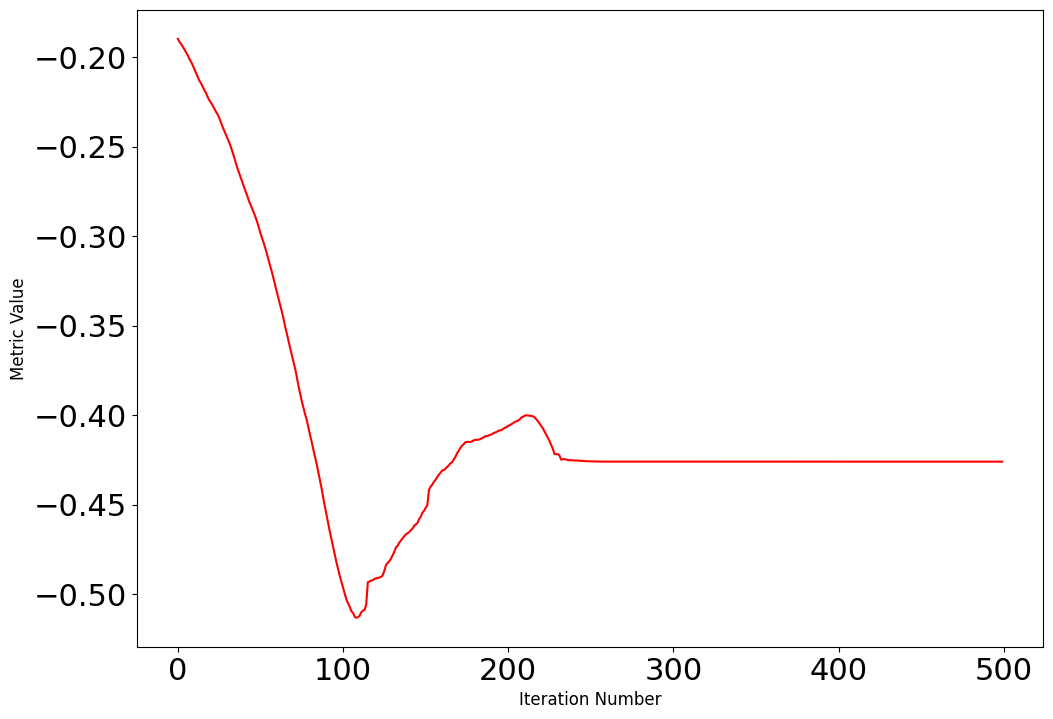

Final metric value: -0.4259513575726266
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (500) exceeded.
20170714_kV_CBCT_12b


InvalidDicomError: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.

In [26]:
# Register the patient CBCT images
image_dict = register_patient(patient_path, True, plot=True) #the second parameter is use_reg_file = True, set to false to use the optimizer 

In [401]:

#The iamge dict contains:
# - the origianl CBCTs and the resmapled (registered) CBCTs
# - names of the CT files and the CBCT files
# - registration matrices used to register the images
# - starting position and spacing of the original CT (which should also be the same spacing as the registered CBCTs)
# - the isocentre is currently broken

#the names of the dict keys are: UID, CBCTs, resampled_CBCTs, isocenters, matrices, starts, isReference




## Generating and plotting SITK images

In [10]:
from sitk_img_tools import generate_sitk_image, save_dicoms
reload(sitk_img_tools)
# note these are also imported in the registration import

<module 'sitk_img_tools' from '/home/trey/APPS/MSc_Work/longiDICOM/Examples/../code/sitk_img_tools.py'>

In [11]:
#Extract the CT filenames from the patient path while excluding the CBCT files:
CT = os.listdir(patient_path)
name_requirement = ['_CT_']
CT = [sub for sub in CT if any(ele in sub for ele in name_requirement)]

In [12]:
#"CT" should contain ONLY the CT filenames if running correctly. 
print(CT)

['20190627_CT_31_MAY_2019']


In [13]:
#generate the sitk image. The following line assumes there is only one CT per file, and that it is the CT which the CBCTs are being registered to. 
ct_sitk = generate_sitk_image(patient_path + CT[0] +"/")


103


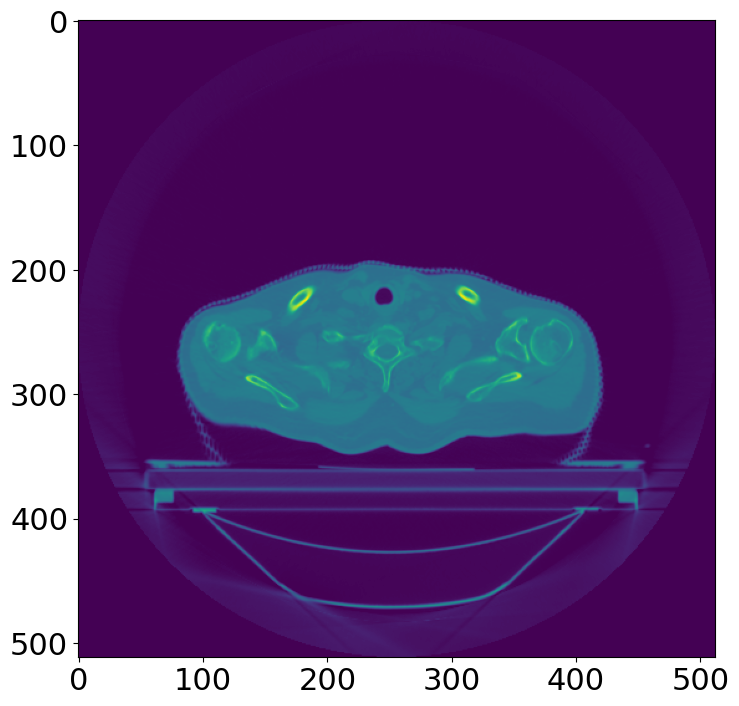

In [14]:
#generate a visualization of an image slice. Here, it is slice 60. 
plt.imshow(sitk.GetArrayFromImage(ct_sitk)[60]) 
test_array = sitk.GetArrayFromImage(ct_sitk)
print(len(test_array))

In [15]:
#generate list of files (called "CBCTs") in the patient directory. Due to naming conventions, require "kV" to be in the CBCT filenames. 
CBCTs = os.listdir(patient_path)
name_requirement = ['kV']
CBCTs = [sub for sub in CBCTs if any(ele in sub for ele in name_requirement)]
print (str(CBCTs))

['20190705_kV_CBCT_2a', '20190703_kV_CBCT_1a', '20190708_kV_CBCT_3a', '20190710_kV_CBCT_4c', '20190712_kV_CBCT_5a']


In [327]:
#old junk used for troubleshooting

#CBCTs = ['20190319_kV_CBCT_1a',
   #'20190319_kV_CBCT_1b',
#   '20190320_kV_CBCT_2a',
   #'20190320_kV_CBCT_2b',
#   '20190321_kV_CBCT_3a',
#   '20190322_kV_CBCT_4a',
#   '20190325_kV_CBCT_5a']

#CBCTs = ['20190605_kV_CBCT_3a', 
#         '20190603_kV_CBCT_1a']

#for f in CBCTs:
#    cbct_sitk=generate_sitk_image(patient_path+f+'/')
#    plt.imshow(sitk.GetArrayFromImage(cbct_sitk)[60])

In [328]:

#more troubleshooting junk

#cbct_sitk=generate_sitk_image(patient_path+'20190724_kV_CBCT_3a/')
#plt.imshow(sitk.GetArrayFromImage(cbct_sitk)[40])

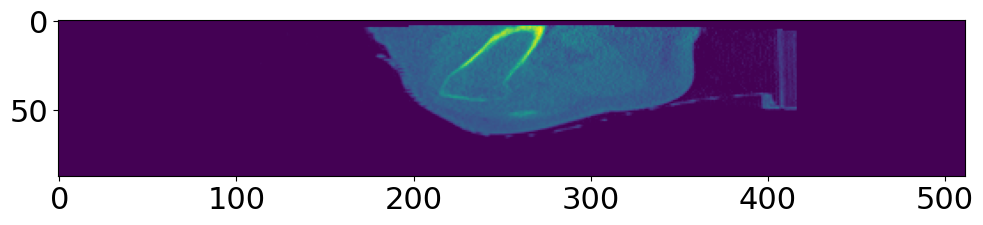

In [16]:
#Generate a CBCT slice visualization
plt.imshow(sitk.GetArrayFromImage(generate_sitk_image(patient_path+CBCTs[0]+"/")[60]))


## Demo using structures from RS

In [66]:
from rs_tools import *
from Slice_Selection.slice_selection import get_image_slice

In [67]:
import rs_tools
importlib.reload( rs_tools)
import Slice_Selection.slice_selection
importlib.reload( Slice_Selection.slice_selection)

<module 'Slice_Selection.slice_selection' from '/home/trey/APPS/MSc_Work/longiDICOM/Examples/../code/Slice_Selection/slice_selection.py'>

In [88]:
RS_file = find_RS_file(patient_path + CT)
RS = dcm.dcmread(patient_path + CT+'/'+RS_file) # should do os.join.path

TypeError: can only concatenate str (not "list") to str

In [35]:
# search for keyword
subgland_ROI_names = find_ROI_names(RS,keyword='sub') # no keywords will show you all ROI names
print(subgland_ROI_names)

[]


In [29]:
# get contour of glands
dict_contours, z_lists = get_all_ROI_contours(subgland_ROI_names, RS)
roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists) # z _smg = centre of roi (z wise)

ZeroDivisionError: division by zero

In [30]:
# get the start positions of the CBCT
start_x, start_y, start_z, spacing = get_start_position_sitk(image_dict[CT]['resampled_CBCTs'][0])
#start_x, start_y, start_z, spacing = get_start_position_dcm(patient_path+'20190712_CT_05_JUL_2019/')\
print(start_x,start_y,start_z,spacing)

-349.5 -266.5 -1004.5 (1.36523438, 1.36523438, 3.0)


In [33]:
# you can either pick an image slice by hand 
#image_slice = 100
# or use this to find the centre of an ROI
img_slice = get_image_slice(start_z, z_smg, spacing)

In [34]:
# get the X Y values of the ROIs for a given slice to plot
roi_x, roi_y = get_ROI_pixel_array(dict_contours[subgland_ROI_names[0]][roi_slice],start_x,start_y,spacing)

IndexError: list index out of range

In [27]:
# plot the ROI on the original CT
plot_ROI(sitk.GetArrayFromImage(ct_sitk)[int(img_slice)], roi_x, roi_y)

NameError: name 'img_slice' is not defined

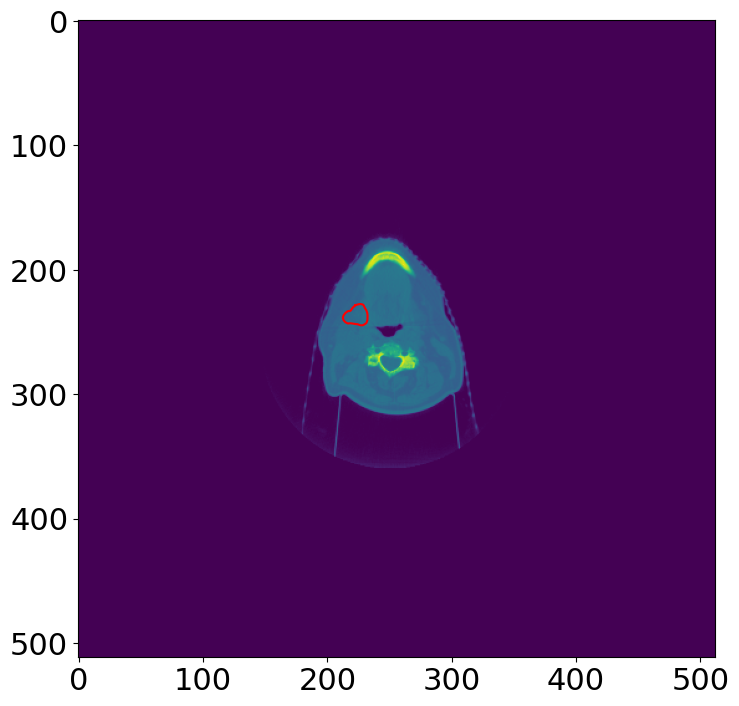

In [26]:
# plot the ROI on one of the registered CBCTs (all x y and slice numbers on the CBCT now correspond to the same slices on the CTs
plot_ROI(sitk.GetArrayFromImage(image_dict['20190712_CT_05_JUL_2019']['resampled_CBCTs'][7])[int(img_slice)], roi_x, roi_y)

### Save registered images

In [439]:
# TO DO -- SAVE SITK IMAGES AS DCMs
#I have code for saving changed DICOMs with new pixel arrays, as well as individual slices as arrays, 
# but I have yet to save the SITK images as dcm

In [440]:
## Saving SITKs as DCMs (Trey)

In [17]:
#make a new array containing the names of all images in the patient's filepath

all_images = CT + CBCTs
print(all_images)

['20190627_CT_31_MAY_2019', '20190705_kV_CBCT_2a', '20190703_kV_CBCT_1a', '20190708_kV_CBCT_3a', '20190710_kV_CBCT_4c', '20190712_kV_CBCT_5a']


In [18]:
#define the output directory for where you want your registered dicom images to be housed 
base_output_directory = '/data/trey/DATA/newRawData/data/RegisteredData/' + patient

In [19]:
print(base_output_directory)

/data/trey/DATA/newRawData/data/RegisteredData/43


In [20]:

def make_image_path(data_path, patient_number, dicom_filename):
    image_pathway = data_path + patient_number + dicom_filename
    return image_pathway



In [23]:

#This is the cell that saves the registered images as dicoms to the desired output directory.
mysitk_image = []
print(len(image_dict[CT[0]]['resampled_CBCTs']))
i=0
print(i)
while (i < len(image_dict[CT[0]]['resampled_CBCTs'])): 
    mysitk_image = image_dict[CT[0]]['resampled_CBCTs'][i]
    data_directory = patient_path+CBCTs[i]

    #The following code works. Commenting it out to test an alternate method
    #CBCTs_output_directory = base_output_directory + "_" + str(i) 
    CBCTs_output_directory = base_output_directory
    
    if not os.path.exists(CBCTs_output_directory):
        os.mkdir(CBCTs_output_directory)
    
    final_output_directory = CBCTs_output_directory + '/'+CBCTs[i]
    
    print(data_directory)
    print(CBCTs_output_directory)
    print(final_output_directory)
    
    save_dicoms(data_directory, mysitk_image, final_output_directory)
    i+=1
    print(i)


#Also copy the original planning CT image to the data folder: 
data_directory = patient_path + CT[0]
CT_output_directory = base_output_directory #+ '_CT/'  #add '_CT' to denote that it's the original CT that the CBCTs are registered to
output_directory = CT_output_directory + '/'+ CT[0]
print(data_directory)
print(output_directory)
if not os.path.exists(CT_output_directory):
    os.mkdir(CT_output_directory)
if not os.path.exists(output_directory):
        os.mkdir(output_directory)
shutil.copytree(data_directory, output_directory, dirs_exist_ok=True)

5
0
/mnt/iDriveShare/Trey/images/43/20190705_kV_CBCT_2a
/data/trey/DATA/newRawData/data/RegisteredData/43
/data/trey/DATA/newRawData/data/RegisteredData/43/20190705_kV_CBCT_2a
[('0008|0005', 'ISO_IR 192'), ('0008|0008', 'ORIGINAL\\PRIMARY\\AXIAL'), ('0008|0012', '20240710'), ('0008|0013', '145315'), ('0008|0016', '1.2.840.10008.5.1.4.1.1.2'), ('0008|0018', '1.2.246.352.221.4907190289491880315.10292724792375816607'), ('0008|0020', '20190531'), ('0008|0021', '20190705'), ('0008|0022', '20190705'), ('0008|0023', '20190705'), ('0008|0030', '085053'), ('0008|0031', '133427.84 '), ('0008|0032', '133431.217'), ('0008|0033', '133315.97 '), ('0008|0050', ''), ('0008|0060', 'CT'), ('0008|0070', 'Varian Medical Systems'), ('0008|0090', ''), ('0008|1090', 'Patient Verification'), ('0010|0010', 'ywQlSuTMxAsATDnF'), ('0010|0020', 'SbysMrHHES5Lds2HWDsWaWKP4 '), ('0010|0030', ''), ('0010|0040', ''), ('0012|0062', 'YES '), ('0012|0063', 'De-identified with Varian Medical Systems DICOM Import Export '),

'/data/trey/DATA/newRawData/data/RegisteredData/43/20190627_CT_31_MAY_2019'

In [352]:
#Trey's troubleshooting between old copy and new copy:

# run this code if there's a second registered CT present
mysitk_image = []
print(len(image_dict[CT[0]]['resampled_CBCTs']))
i=0
print(image_dict[CT[0]])

4
{'UID': '1.2.246.352.221.5590721048385698903.8515963155540189104', 'CBCTs': ['20190913_kV_CBCT_1a', '20190913_kV_CBCT_1b', '20190913_kV_CBCT_1c', '20190913_kV_CBCT_1d'], 'resampled_CBCTs': [<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fcd2615ef00> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fcd261686c0> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fcd2615eba0> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fcd26168f30> >], 'isocenters': [], 'matrices': [array([[ 9.99999999e-01,  0.00000000e+00,  3.49065850e-05,
         2.84942423e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.40593999e+01],
       [-3.49065850e-05,  0.00000000e+00,  9.99999999e-01,
        -3.87000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[ 9.99999999e-0

In [32]:


def extract_dicom_tags(dicom_file_path):
    # Load the DICOM file
    dicom_data = dcm.dcmread(dicom_file_path)

    # Extract tags and their corresponding values
    dicom_tags = {}
    EXCLUDED_TAG = "(7fe0, 0010)"
    for elem in dicom_data.iterall():
        tag_name = elem.tag
        #print("elem.tag: ", str(elem.tag))
        #print(type(elem.tag))
        #print(str(tag_name) != EXCLUDED_TAG)
        if str(tag_name) != EXCLUDED_TAG:  # Skip the pixel data tag
            tag_name = elem.tag
            tag_value = elem.value
            #if str(tag_name) == "(0018, 0050)": #slice thickness
        #   if str(tag_name) == "(0028|1052)": # Rescale Intercept                   
           # if str(tag_name) == "(0028|1053)": # Rescale Slope                      
            if str(tag_name) == "(0028|1054)": # Rescale Type 
                print(tag_name)
                print(tag_value)
            dicom_tags[tag_name] = tag_value

    return dicom_tags
    
def print_dicom_tags(dicom_tags):
    for tag, value in dicom_tags.items():
        print(f"Tag: {tag}, Value: {value}")

In [153]:
dicom_file_path = "/mnt/iDriveShare/Trey/newRawData/data/TEST/65/20200529_CT_27_MAY_2020/CT.1.2.246.352.221.4629445125817670061.2271150032646175665.dcm"
dicom_tags_original = extract_dicom_tags(dicom_file_path)

dicom_file_path_2 = "/data/trey/DATA/newRawData/data/RegisteredData/65/20200529_CT_27_MAY_2020/CT.1.2.246.352.221.4629445125817670061.2271150032646175665.dcm"
dicom_tags_copied = extract_dicom_tags(dicom_file_path_2)

dicom_file_path_3 = '/mnt/iDriveShare/Trey/1_RAWDATA/data/MET7/2111621_20180716/XY/CT.1.2.840.113704.1.111.5512.1531755676.1802.dcm'
dicom_tags_copied = extract_dicom_tags(dicom_file_path_3)
#print(dicom_tags_original)

In [138]:
def compare_dicom_files(tags1, tags2):
    differences = []
    
    # Compare tags in both files
    all_tags = set(tags1.keys()).union(tags2.keys())  # All unique tags from both files
    
    for tag in all_tags:
        value1 = tags1.get(tag, None)
        value2 = tags2.get(tag, None)
        #print("value1: ", value1)
        #print("value2: ", value2)
        
        if value1 != value2:
            differences.append({
                'Tag': tag,
                'File 1 Value': value1,
                'File 2 Value': value2
            })
    
    return differences

def print_differences(differences):
    if differences:
        print("Differences between the DICOM files:")
        for diff in differences:
            print(f"Tag: {diff['Tag']}")
            print(f"  File 1 Value: {diff['File 1 Value']}")
            print(f"  File 2 Value: {diff['File 2 Value']}")
            print('-' * 50)
    else:
        print("No differences found between the files.")
    return          

In [1]:
differences = compare_dicom_files(dicom_tags_original, dicom_tags_copied)
print_differences(differences)


NameError: name 'compare_dicom_files' is not defined